In [1]:
%load_ext autoreload
%autoreload 2

from robot.robot import Panda
import rospy
import numpy as np
import PyKDL

In [2]:
rospy.init_node("robot_controller", anonymous=True)
panda = Panda()

[ INFO] [1673359148.383938210]: Loading robot model 'panda'...
[ INFO] [1673359149.973133602]: Ready to take commands for planning group panda_manipulator.
[ INFO] [1673359150.581516528]: Ready to take commands for planning group panda_hand.


In [ ]:
hand = panda.robot.get_group('panda_hand')
hand.get_current_state()

#### Sample along the cartesian line to plan the robot path

In [ ]:
import pickle

bottleneck_pose = panda.get_endpoint_pose()
print(bottleneck_pose)
print('pos:{}, ori:{}'.format(bottleneck_pose.p, bottleneck_pose.M.GetQuaternion()))
#np.save('trial_code/bottleneck_pose.pickle', bottleneck_pose)

In [ ]:
# Sample along the cartesian line to plan the robot path

import copy
import pprint

arm_group = panda.arm_group

current_position = panda.get_endpoint_pose().p
target_position = bottleneck_pose.p
pprint.pprint('current:{}, target:{}'.format([*current_position], [*target_position]))
current_orientation = panda.get_endpoint_pose().M.GetQuaternion()
target_orientation = bottleneck_pose.M.GetQuaternion()
pprint.pprint('current:{}, target:{}'.format([*current_orientation], [*target_orientation]))

samples = np.linspace([*current_position], 
                    [*target_position], 5, True)
# samples = np.linspace([*current_position,*current_orientation], 
#                     [*target_position,*target_orientation], 5, True)
waypoints = []
for sample in samples:
    pprint.pprint('sample:{}'.format(sample))
    wpose = arm_group.get_current_pose().pose
    wpose.position.x = sample[0]
    wpose.position.y = sample[1]
    wpose.position.z = sample[2]
    # wpose.orientation.x = sample[3]
    # wpose.orientation.y = sample[4]
    # wpose.orientation.z = sample[5]
    # wpose.orientation.w = sample[6]
    waypoints.append(copy.deepcopy(wpose))

final_pose = arm_group.get_current_pose().pose
final_pose.position.x = target_position[0]
final_pose.position.y = target_position[1]
final_pose.position.z = target_position[2]
final_pose.orientation.x = target_orientation[0]
final_pose.orientation.y = target_orientation[1]
final_pose.orientation.z = target_orientation[2]
final_pose.orientation.w = target_orientation[3]
waypoints.append(copy.deepcopy(final_pose))

(plan, fraction) = arm_group.compute_cartesian_path(waypoints,1.0, 0.0)
print('Constraints followed fraction: {}'.format(fraction))
plan = arm_group.retime_trajectory(
    arm_group.get_current_state(), plan, 0.1, 0.1,
    algorithm="time_optimal_trajectory_generation")
status = arm_group.execute(plan, False)
#panda.move_towards_pose(bottleneck_pose)

# to enable interactive plot
%matplotlib qt

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection ='3d')

while True:
    end_pose = panda.get_endpoint_pose()
    position = end_pose.p
    orientation = end_pose.M.GetQuaternion()
    ax.scatter(position[0], position[1], position[2])
    if not panda._is_moving():
        break
ax.set_title('Travelled trajectory')
plt.show()

#### Function to plot the list of PyKLD Frames

In [10]:
%matplotlib qt

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#poses : [KDLFrames]
def plot_poses(poses):
    fig = plt.figure()
    ax = fig.add_subplot(projection ='3d')
    for pose in poses:
        position = pose.p
        orientation = pose.M.GetQuaternion()
        ax.scatter(position[0], position[1], position[2])
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title('Ploted poses')
    plt.show()

In [22]:
panda.move_to_neutral()

True

#### Generate cartesian path with orientation constraint

In [ ]:
## Cartesian plan with orientation constraint

arm_group = panda.arm_group
#bottleneck_pose_path = '../Data/Plus/Single_Demo/Raw/bottleneck_pose_vector.npy'

from moveit_msgs.msg import Constraints, OrientationConstraint
from geometry_msgs.msg import Quaternion
from std_msgs.msg import Header
import PyKDL
import rospy

if bottleneck_pose is None:
    bottleneck_pose = np.load('trial_code/bottleneck_pose.pickle.npy', allow_pickle=True)
print(bottleneck_pose)
print('pos:{}, ori:{}'.format(bottleneck_pose.p, bottleneck_pose.M.GetQuaternion()))
orientation = bottleneck_pose.M.GetQuaternion()
#orientation = [0.9991657566837994, -0.013507814375322271, -0.00901283832961572, 0.037471300571727]
constraints = Constraints()
constraint = OrientationConstraint()
constraint.header = Header(0, rospy.Time.now(), 'panda_link0')

ori = Quaternion()
ori.x = orientation[0]
ori.y = orientation[1]
ori.z = orientation[2]
ori.w = orientation[3]

constraint.link_name = 'panda_hand_tcp'
constraint.orientation = ori
constraint.absolute_x_axis_tolerance = 0.00001
constraint.absolute_y_axis_tolerance = 0.00001
constraint.absolute_z_axis_tolerance = 0.00001
#constraint.parameterization = 1
constraint.weight = 10

constraints.orientation_constraints = [constraint]
constraints.name = 'panda_hand_fixed_orientation'

panda.move_towards_pose(bottleneck_pose, constraints=constraints, wait=False)

# to enable interactive plot
%matplotlib qt

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection ='3d')

while True:
    end_pose = panda.get_endpoint_pose()
    position = end_pose.p
    orientation = end_pose.M.GetQuaternion()
    ax.scatter(position[0], position[1], position[2])
    if not panda._is_moving():
        break
ax.set_title('Travelled trajectory')
plt.show()

#### Plot all the self-supervised trajectories

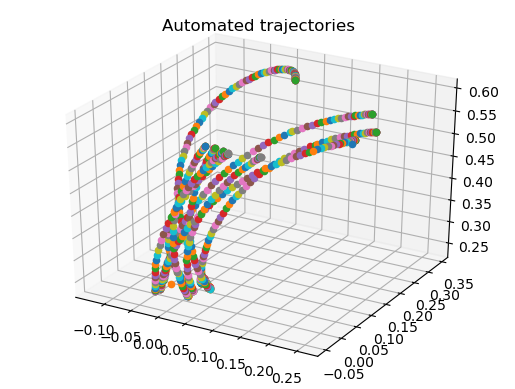

In [6]:
# Plot autolated trajectories

%matplotlib qt
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig = plt.figure()
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
# Data path
task_name = 'Drop'
num_trajectories = 10
image_path = '../Data/' + str(task_name) + '/Automatic_Coarse/Image_To_Pose_Dataset/images_' + str(num_trajectories) + '.npy'
pose_xysc_path = '../Data/' + str(task_name) + '/Automatic_Coarse/Image_To_Pose_Dataset/endpoint_to_bottleneck_poses_3dof_sin_cos_' + str(num_trajectories) + '.npy'
pose_z_path = '../Data/' + str(task_name) + '/Automatic_Coarse/Image_To_Pose_Dataset/endpoint_heights_' + str(num_trajectories) + '.npy'

# Data load
images = np.load(image_path)
poses_xysc = np.load(pose_xysc_path)
poses_z = np.load(pose_z_path)

# print(images.shape)
# print(poses_z)
# print(images[0].transpose((1, -1, 0)).shape)
for index in range(images.shape[0]):
    pose_x = poses_xysc[index][0]
    pose_y = poses_xysc[index][1]
    pose_z = poses_z[index]
    #print('x:{} , y:{} , z:{}'.format(pose_xy[0],pose_xy[1],pose_z))
    ax.scatter(pose_x,pose_y,pose_z)

    # add image annotations
    # ab = AnnotationBbox(OffsetImage(images[index].transpose((1, -1, 0)) ), (pose_x, pose_y, pose_z), frameon=False)
    # ax.add_artist(ab)

# syntax for plotting
ax.set_title('Automated trajectories')
plt.show()

#### Test the Trained network

In [3]:
# Test the trained model

import rospy
from robot.robot import Panda
from robot.camera import Camera
from controllers.coarse_controller import CoarseController
from common import config


rospy.init_node('test_model')
panda = Panda()
camera = Camera()

estimation_method = 'filtering_with_predicted_uncertainty'
task_name=config.TASK_NAME
ros_rate = rospy.Rate(30)

coarse_controller = CoarseController(task_name, panda, camera, ros_rate, config.NO_OF_TRAJECTORIES)


[ INFO] [1673888381.093285392]: Ready to take commands for planning group panda_manipulator.
[ INFO] [1673888381.494362938]: Ready to take commands for planning group panda_hand.
reset start
reset done
Camera initialised.
Loading network from: ../Networks/Plus/image_to_pose_network_coarse_50.torch


In [ ]:
coarse_controller.run_episode(estimation_method)

In [4]:
#panda.move_to_joint_angles(config.ROBOT_INIT_JOINT_ANGLES)
predicted_poses = []
predicted_poses.append(panda.get_endpoint_pose())

In [48]:
import numpy as np
import torch
from robot import kdl_utils
import cv2

rgb_image = camera.capture_cv_image(resize_image=True, show_image=True, show_big_image=True)
# cv2.imshow("Current Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
true_endpoint_pose = panda.get_endpoint_pose()
z = true_endpoint_pose.p[2]
rgb_image = rgb_image / 255.0
torch_image = np.moveaxis(rgb_image, 2, 0)
image_tensor = torch.unsqueeze(torch.tensor(torch_image, dtype=torch.float32), 0)
z_tensor = torch.unsqueeze(torch.unsqueeze(torch.tensor(z), 0), 0)

prediction = coarse_controller.image_to_pose_network.forward(image_tensor, z_tensor).detach().cpu().numpy()[0]
predicted_theta = np.arctan2(prediction[2], prediction[3])
predicted_current_to_bottleneck_pose_3dof = np.array([prediction[0], prediction[1], predicted_theta])
predicted_current_to_bottleneck_pose = kdl_utils.create_vertical_pose_from_x_y_z_theta(predicted_current_to_bottleneck_pose_3dof[0], predicted_current_to_bottleneck_pose_3dof[1], z, predicted_current_to_bottleneck_pose_3dof[2])
# Convert this prediction into the live robot frame
predicted_bottleneck_pose = true_endpoint_pose * predicted_current_to_bottleneck_pose
# z in this pose is same as true_endpoint pose
predicted_bottleneck_pose_3dof = kdl_utils.create_pose_3dof_from_pose(predicted_bottleneck_pose)
 
estimated_bottleneck_pose_3dof = predicted_bottleneck_pose_3dof
# Compute the target pose in the live frame
from common import config
bottleneck_path = '../Data/' + str(config.TASK_NAME) + '/Single_Demo/Raw/bottleneck_pose_vector_vertical.npy'
bottleneck_pose_vector = np.load(bottleneck_path)
bottleneck_height = bottleneck_pose_vector[2]
target_pose = kdl_utils.create_vertical_pose_from_x_y_z_theta(estimated_bottleneck_pose_3dof[0], estimated_bottleneck_pose_3dof[1], bottleneck_height, estimated_bottleneck_pose_3dof[2])


#predicted_pose = coarse_controller._predict_bottleneck_pose_3dof()



In [49]:
#print(target_pose)
#predicted_poses.append(panda.get_endpoint_pose())
predicted_poses.append(target_pose)
print('position:{}, orientation:{}'.format(target_pose.p, target_pose.M.GetQuaternion()))

position:[     0.64207,   -0.056033,   0.0845888], orientation:(0.9998982251325906, 0.014266722703376613, 8.735848146506522e-19, 6.122610804408733e-17)


In [51]:
plot_poses(predicted_poses)

In [50]:
panda.move_towards_pose_cartesian(target_pose)

True

In [47]:
panda.move_to_joint_angles(config.ROBOT_INIT_JOINT_ANGLES)

True

##### Get the Robot/Task Init position for config file

In [11]:
import numpy as np
from common import config
from moveit_commander import conversions

panda.move_to_joint_angles(config.ROBOT_INIT_JOINT_ANGLES)
angles = panda.arm_group.get_current_joint_values()
print('ROBOT_INIT_JOINT_ANGLES: {}'.format(repr(np.round(angles, 4))))

# Task Space
pose_to_list = conversions.pose_to_list(panda.arm_group.get_current_pose().pose)
position = pose_to_list[:3]
print('DEMO_START_MID_POS: {}'.format(repr(np.round(position, 2))))
orientation = panda.arm_group.get_current_rpy()
print('DEMO_START_MID_ORI: {}'.format(repr(np.round(orientation, 3))))





ROBOT_INIT_JOINT_ANGLES: array([ 0.0186,  0.0507, -0.0768, -1.6882,  0.0051,  1.7873,  0.8128])
DEMO_START_MID_POS: array([ 0.59, -0.03,  0.46])
DEMO_START_MID_ORI: array([-3.139, -0.049, -0.086])


In [2]:
camera.shutdown()

NameError: name 'camera' is not defined

In [ ]:
panda.arm_group.get_current_pose().pose

In [ ]:
position1 = panda.robot.get_current_state().joint_state.position

position2 = panda.get_joint_angles()

print('Position1:{}, \n position2:{}'.format(position1, position2))

from robot import kdl_utils
kdl_utils.create_kdl_array_from_joint_angles(position1)

In [ ]:
panda.urdf.joint_map

In [ ]:
#from urdf_parser_py.urdf import URDF
#urdf = URDF.from_parameter_server()
#rospy.get_param('robot_description')
from moveit_commander import conversions
from moveit_commander.conversions import pose_to_list
pose = panda.arm_group.get_current_pose().pose
print(pose)
print(pose_to_list(panda.arm_group.get_current_pose().pose))

from robot import kdl_utils
robot_pose = panda.get_endpoint_pose()
# print(robot_pose.M.GetQuaternion())
# print(robot_pose)
# print(kdl_utils.create_vector_from_pose(robot_pose))

from moveit_commander import conversions
pose_list = conversions.pose_to_list(pose)
print(pose_list[3:])
pose_frame = PyKDL.Frame(PyKDL.Rotation.Quaternion(*pose_list[3:]), PyKDL.Vector(*pose_list[:3]))
print(kdl_utils.create_vector_from_pose(pose_frame))


Loading network from: ../Networks/Plus/image_to_pose_network_coarse_10.torch


In [4]:
#coarse_controller.run_episode(estimation_method)
panda.arm_group.set_pose_reference_frame(panda.get_endpoint_pose())

ArgumentError: Python argument types in
    MoveGroupInterface.set_pose_reference_frame(MoveGroupInterface, Frame)
did not match C++ signature:
    set_pose_reference_frame(moveit::planning_interface::MoveGroupInterfaceWrapper {lvalue}, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >)
    set_pose_reference_frame(moveit::planning_interface::MoveGroupInterfaceWrapper {lvalue}, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >)

In [ ]:
panda.get_endpoint_pose()